# Week 4: CNN
Upul Senanayake

This week we will focus on:
1. How to implement a CNN on AWS
2. How to implement hyperparmeter optimisation (HPO) on AWS SageMaker
3. How to deploy the best model from HPO. 
4. Cloud watch


### 1. Build, train and deploy a CNN model using our own script in AWS SageMaker 

Your tasks are to : 

- **Modify the script mnist_MLP_tf2 last week to build, train and deploy a CNN.**

- **Take 5 mintues to see which part of the script mode needs to change** 


In [48]:
%%sh
sudo chown ec2-user lost+found
sudo chgrp ec2-user lost+found

In [49]:
# We first need to import the necessary libraries and define some environment variables  
## Import sagemaker and retrieve IAM role, which determines your user identity and permissions
import os
import sagemaker #import sagemaker  
from sagemaker import get_execution_role
print(sagemaker.__version__) #print the sagemaker version
sagemaker_session = sagemaker.Session() ### Manages interactions with the Amazon SageMaker APIs and 
                           ### any other AWS services needed e.g. S3
role = sagemaker.get_execution_role() ### Get and save the IAM role as environment variable

2.72.1


In [50]:
print(role)
print(sagemaker_session)

arn:aws:iam::815181084889:role/service-role/AmazonSageMaker-ExecutionRole-20220121T085620


In [51]:
## Import os, keras, numpy, pyplot and the fashion MNIST data 
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist
from matplotlib import pyplot
import numpy as np

(x_train,y_train), (x_test,y_test)  = fashion_mnist.load_data()

### Run the script mode on the local EC2

Remmber to create local directory to store the training and test data (see the content from the previous week)

In [52]:
%%writefile mnist_CNN_tf2.py

import argparse, os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical

import subprocess
import sys


# AWS script mode doesn't support requirements.txt

def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])


if __name__ == '__main__':

    # Hyperparameters
    ## all set at particular value here. we will learn how to tune parameters without setting a default
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--learning-rate', type=float, default=0.01)
    parser.add_argument('--batch-size', type=int, default=128)
    parser.add_argument('--dense-layer', type=int, default=512)
   

    parser.add_argument('--gpu-count', type=int, default=os.environ['SM_NUM_GPUS'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--training', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    parser.add_argument('--validation', type=str, default=os.environ['SM_CHANNEL_VALIDATION'])

    args, _ = parser.parse_known_args()

    epochs = args.epochs
    lr = args.learning_rate
    batch_size = args.batch_size
    dense_layer = args.dense_layer
 

    gpu_count = args.gpu_count
    model_dir = args.model_dir
    training_dir = args.training
    validation_dir = args.validation

    x_train = np.load(os.path.join(training_dir, 'training.npz'))['image']
    y_train = np.load(os.path.join(training_dir, 'training.npz'))['label']
    x_test = np.load(os.path.join(validation_dir, 'test.npz'))['image']
    y_test = np.load(os.path.join(validation_dir, 'test.npz'))['label']

    # input image dimensions
    img_rows, img_cols = 28, 28

    # Tensorflow needs image channels last, e.g. (batch size, width, height, channels)
    if K.image_data_format() == 'channels_last':
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
        batch_norm_axis = -1
    else:

        print('Channels first, exiting')
        exit(-1)

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # Normalize pixel values
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    # Convert class vectors to binary class matrices
    num_classes = 10
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    model = tf.keras.Sequential()
    # Must define the input shape in the first layer of the neural network
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(28, 28, 1)))
    #### 1st convolution layer
    ######## Convolutional layer with 64 filters - n of filters to extract
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    #### downsample using a maxpooling oporations\
    #### feed this into the next set of convolutional layers
    # 2nd convolution layer
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    # Flatten and classify
    #### flattern spacial information into a vector, and learn the final probability distribution for
    #### class membership
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    # Take a look at the model summary
    model.summary()

    if gpu_count > 1:
        model = multi_gpu_model(model, gpus=gpu_count)

    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.local_variables_initializer())

    model.fit(x_train, y_train,
              batch_size=batch_size,
              validation_split=0.1,
              epochs=epochs)
    print(model.summary())
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Validation loss    :', score[0])
    print('Validation accuracy:', score[1])

    # save Keras model for Tensorflow Serving
    model.save(os.path.join(model_dir, '1'))

Overwriting mnist_CNN_tf2.py


In [53]:


#Import tensorflow from sagemaker
from sagemaker.tensorflow import TensorFlow

#Set environment variables - file paths to data and for output
local_training_input_path = 'file://data/training.npz'
local_test_input_path = 'file://data/test.npz'
output = 'file:///tmp'

tf_estimator = TensorFlow(entry_point='mnist_CNN_tf2.py', #path to local python source file to be executed
                          base_job_name='CNN-local', #name the job for job management                                                      
                          role = role, #the IAM ROLE ARN for the model - unique user ID
                          source_dir ='.', #path to the directory where any other dependancies are apart from entry point
                          instance_count = 1, #the number of EC2 intances to use
                          instance_type ='local', # Type of EC2 instance to use local = this one! 
                          framework_version = '2.1.0', # Tensorflow version for executing your tf code
                          py_version ='py3', #version of python for executing your model training code
                          script_mode =True, #enables us to use our python script to train the model
                          hyperparameters={'epochs': 1}, #hyperparameters used by our custom TensorFlow code during model training
                          output_path = output) #location for saving the results. Default = saved in the default S3 bucket.

#Note, Estimator is a high level interface for SageMaker training

In [54]:
tf_estimator.fit({'training': local_training_input_path, 'validation': local_test_input_path})

Creating 65e6ctunzg-algo-1-csff8 ... 
Creating 65e6ctunzg-algo-1-csff8 ... done
Attaching to 65e6ctunzg-algo-1-csff8
65e6ctunzg-algo-1-csff8 | 2022-02-11 08:33:01,953 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
65e6ctunzg-algo-1-csff8 | 2022-02-11 08:33:01,962 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
65e6ctunzg-algo-1-csff8 | 2022-02-11 08:33:03,055 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
65e6ctunzg-algo-1-csff8 | 2022-02-11 08:33:03,079 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
65e6ctunzg-algo-1-csff8 | 2022-02-11 08:33:03,101 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
65e6ctunzg-algo-1-csff8 | 2022-02-11 08:33:03,114 sagemaker-containers INFO     Invoking user script
65e6ctunzg-algo-1-csff8 | 
65e6ctunzg-algo-1-csff8 | Training Env:
65e6ctunzg-algo-1-csff8 | 
65e6ctunzg-algo-1-csff8 | {
65e6ctunzg-al

### Upload the data to S3 bucket



*Last week code*

*This week* 

In [55]:
# Call data from S3 bucket - look in S3 section of AWS


training_input_path = 's3://sagemaker-us-east-1-815181084889/keras-mnist-fashion/training/training.npz'
test_input_path = 's3://sagemaker-us-east-1-815181084889/keras-mnist-fashion/validation/test.npz'

#CHECK PATHS
print(training_input_path)
print(test_input_path)

s3://sagemaker-us-east-1-815181084889/keras-mnist-fashion/training/training.npz
s3://sagemaker-us-east-1-815181084889/keras-mnist-fashion/validation/test.npz


#### Configuring metrics from the job logs

Sagemaker can get training metrics directly from the logs and send them to the Cloudwatch metrics

In [56]:
keras_metric_definition = [
    {'Name': 'train:loss', 'Regex': '.*loss: ([0-9\\.]+) - accuracy: [0-9\\.]+.*'},
    {'Name': 'train:accuracy', 'Regex': '.*loss: [0-9\\.]+ - accuracy: ([0-9\\.]+).*'},
    {'Name': 'validation:accuracy', 'Regex': '.*step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_accuracy: ([0-9\\.]+).*'},
    {'Name': 'validation:loss', 'Regex': '.*step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: ([0-9\\.]+) - val_accuracy: [0-9\\.]+.*'},
    {'Name': 'sec/steps', 'Regex': '.* (\d+)[mu]s/step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_accuracy: [0-9\\.]+'}
]

#### Train with managed instances

In [57]:
tf_estimator = TensorFlow(entry_point='mnist_CNN_tf2.py',  #Python script
                          base_job_name='Mnsit-CNN-Training',
                          source_dir = '.',
                          role=role,
                          instance_count=1, 
                          instance_type='ml.m4.xlarge', # instance type
                          framework_version='2.1.0', # Tensorflow version
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={'epochs': 10},
                          metric_definitions=keras_metric_definition
                         ) 

In [58]:
tf_estimator.fit({'training': training_input_path, 'validation': test_input_path})   

2022-02-11 08:34:15 Starting - Starting the training job...
2022-02-11 08:34:40 Starting - Launching requested ML instancesProfilerReport-1644568430: InProgress
.........
2022-02-11 08:36:01 Starting - Preparing the instances for training......
2022-02-11 08:37:14 Downloading - Downloading input data...
2022-02-11 08:37:41 Training - Downloading the training image..2022-02-11 08:37:54,119 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2022-02-11 08:37:54,125 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-11 08:37:55,409 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-11 08:37:55,428 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-11 08:37:55,445 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-11 08:37:55,457 sagemaker-containers INFO     Invoking user script
Training Env:
{
    "additional_framewor

**How to use CloudWatch to obtain metrics measurements?**

### Deploy the model

**Option 1**: Similar to Week 2 and 3. 

In [59]:
# Use code from weeks 2 and 3 to achieve this. 
import time

tf_endpoint_name = 'keras-tf-fmnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime()) #give the endpoint a name.
#used the time and date from the time library

#deploy() Deploys the Model to an Endpoint and optionally return a Predictor.
predictor = tf_estimator.deploy(initial_instance_count=1, # The initial number of instances to run in the Endpoint created from this Model.
                                   instance_type='ml.t2.medium', # The EC2 instance type to deploy this Model to.
                                   endpoint_name=tf_endpoint_name) # The name of the endpoint to create     

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


--------!

**Option 2**: Deploy directly from model artifacts



In [60]:
from sagemaker.tensorflow import TensorFlowModel
import time
import boto3
tf_endpoint_name = 'keras-tf-fmnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
iam = boto3.client('iam')
model = TensorFlowModel(model_data='s3://sagemaker-us-east-1-815181084889/Mnsit-CNN-Training-2022-02-11-00-14-25-911/output/model.tar.gz',
                       role='AmazonSageMaker-ExecutionRole-20220121T085620',
                       framework_version='2.1.0' # Tensorflow version
                       )

predictor = model.deploy(initial_instance_count=1,
                         instance_type='ml.t2.medium', # The EC2 instance type to deploy this Model to.
                         endpoint_name=tf_endpoint_name)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---------!

#### Prediction

[[9.54622694e-04 3.28439285e-08 6.93572000e-01 1.37454321e-04
  2.69765675e-04 1.59249880e-09 3.05065155e-01 2.76921180e-10
  1.00450438e-06 2.00788430e-09]
 [2.49211562e-09 7.65225607e-08 3.52384177e-10 1.28462844e-07
  3.66325775e-10 2.26512566e-05 2.26094876e-09 1.63053264e-04
  1.95218988e-08 9.99814093e-01]
 [5.66867220e-06 3.94699612e-07 2.45582419e-06 1.22843204e-07
  8.21090794e-07 9.63539779e-01 3.67765665e-06 3.45339589e-02
  1.88618549e-03 2.69397260e-05]
 [2.18175075e-04 5.47203342e-07 7.32864737e-06 9.99482632e-01
  1.67521881e-04 6.03026629e-10 1.21959049e-04 1.02172903e-09
  1.71679426e-06 1.44623662e-11]
 [2.68587726e-03 9.16992121e-06 8.96133423e-01 1.11859618e-03
  5.94614000e-02 2.12943769e-06 4.03619371e-02 1.46992238e-06
  2.25290467e-04 7.03209253e-07]
 [9.11185180e-06 2.45031310e-06 6.88664103e-03 2.54341267e-05
  9.91753042e-01 1.13725402e-08 1.31883228e-03 1.78626308e-07
  4.26251290e-06 1.93624707e-08]
 [5.50235697e-08 3.91519206e-10 8.57259366e-08 2.91486071e

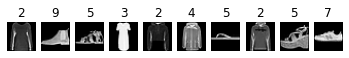

In [61]:
  %matplotlib inline
import random #random number generator for random sampling
import matplotlib.pyplot as plt #for plotting

#select 10 of the test samples (images) randomly
num_samples = 10
indices = random.sample(range(x_test.shape[0] - 1), num_samples)
images = x_test[indices]/255
labels = y_test[indices]

for i in range(num_samples): #plot them with their labels 
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
# Generate predictions for those random test images
# Apply the preductor() function to a Predictor oject
# It returns inferences for the given input - in this case the images

prediction = predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction) #save the predictions as a np.array (softmax decimal probabilties)
print(prediction)
predicted_labels = prediction.argmax(axis=1) #use argmax to turn the predictions into class labels
print('Predicted labels are: {}'.format(predicted_labels)) # print out the labels

#### Remember to delete the endpoint

In [62]:
predictor.delete_endpoint()

### 3. HyperParameter Optimisation

There are **3** different types of hyperparameters:  
   + Categorical parameters  are defined by passing the list of possible values to **CategoricalParameter(list)**
   + Continuous parameters can take any real number value between the minimum and maximum value, defined by **ContinuousParameter(min, max)**
   + Integer parameters can take any integer value between the minimum and maximum value, defined by **IntegerParameter(min, max)**



In [63]:
# Define parameter ranges :

from sagemaker.tuner import IntegerParameter, ContinuousParameter

hyperparameter_ranges = { 
    'epochs' :       IntegerParameter(5, 10), 
    'learning-rate': ContinuousParameter(0.001, 0.1, scaling_type='ReverseLogarithmic'), 
    'batch-size':    IntegerParameter(32, 1024),
    'dense-layer':   IntegerParameter(32, 1024),
}#Dictionary of parameter ranges. Can be one of three types: Continuous, Integer, or Categorical. The keys of the dictionary are the names of the hyperparameter, and the values are the appropriate parameter range class to represent the range.

print(hyperparameter_ranges)



{'epochs': <sagemaker.parameter.IntegerParameter object at 0x7f0ec2d10fd0>, 'learning-rate': <sagemaker.parameter.ContinuousParameter object at 0x7f0ec2d108d0>, 'batch-size': <sagemaker.parameter.IntegerParameter object at 0x7f0ec2d10f98>, 'dense-layer': <sagemaker.parameter.IntegerParameter object at 0x7f0ec2d10a58>}


Need to specify the objective metric that we wish to tune. This includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. 

In [64]:
# Use this if Tensorflow 2 is used
objective_metric_name = 'validation_accuracy' #name for the metric for evaluating training jobs

objective_type = 'Maximize' #do we want to minimise or maximise the named objective metric?

metric_definitions = [
    {'Name': 'training_loss',        'Regex': 'loss: ([0-9\\.]+)'},
    {'Name': 'training_accuracy',    'Regex': 'accuracy: ([0-9\\.]+)'},
    {'Name': 'validation_loss',      'Regex': 'val_loss: ([0-9\\.]+)'},
    {'Name': 'validation_accuracy',  'Regex': 'val_accuracy: ([0-9\\.]+)'},
    {'Name': 'training_precision',   'Regex': 'precision: ([0-9\\.]+)'}
    ] #A list of dictionaries that defines the metric(s) used to evaluate the training jobs (default: None). 
    # Each dictionary contains two keys: ‘Name’ for the name of the metric, and ‘Regex’ for the regular expression
    # used to extract the metric from the logs.

In [65]:
from sagemaker.tensorflow import TensorFlow

# Configure a training job using the Tensorflow estimator, the parameter ranges and the metric defined above.
# Let's run ten individual jobs, two by two.

tf_estimator = TensorFlow(entry_point='mnist_CNN_tf2.py',  
                          role=role,
                          instance_count=1, 
                          instance_type='ml.m4.xlarge',
                          framework_version='2.1.0', 
                          py_version='py3',
                          script_mode=True,
                          # Optional - see notes from Week 2 Lab
                          use_spot_instances=True,        # Use spot instance
                          max_run=3600,                   # Max training time
                          max_wait=7200)    
    
from sagemaker.tuner import HyperparameterTuner

#HyperparameterTuner() Defines interaction with Amazon SageMaker hyperparameter tuning jobs.
#Creates a HyperparameterTuner instance.

# we pass the tf_estimator to HyperparameterTuner(), and pass in the objective_metric_name, 
#objective_type and metric_definitions that we defined in the previous cell
tuner = HyperparameterTuner(tf_estimator,
                            objective_metric_name, #see cell above for definition
                            hyperparameter_ranges, #see cell above for definition
                            metric_definitions, #see cell above for definition
                            max_jobs=4,  #the maximum number of total training jobs to start - I set 4 just for illustration and time waiting
                            max_parallel_jobs=2, #Maximum number of parallel training jobs to start
                            objective_type=objective_type,#see cell above for definition
                            base_tuning_job_name="HPO-Mnist-CNN"
                           ) 



In [ ]:
#fit is used to train the model
tuner.fit({'training': training_input_path, 'validation': test_input_path})

............................................................................................................................................

### Inspect HPO jobs on AWS

In [29]:
import sagemaker
import boto3
from sagemaker.tuner import HyperparameterTuner
tuner = HyperparameterTuner.attach('HPO-Mnist-CNN-220211-0103') #
analytics = tuner.analytics()
df = analytics.dataframe()
df

,batch-size,dense-layer,epochs,learning-rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,436.0,304.0,10.0,0.078898,HPO-Mnist-CNN-220211-0103-004-a43be94f,Completed,0.9038,2022-02-11 01:16:23+00:00,2022-02-11 01:23:22+00:00,419.0
1,103.0,269.0,5.0,0.044785,HPO-Mnist-CNN-220211-0103-003-933e9582,Completed,0.9017,2022-02-11 01:15:20+00:00,2022-02-11 01:19:27+00:00,247.0
2,855.0,582.0,8.0,0.034250,HPO-Mnist-CNN-220211-0103-002-f9ff562b,Completed,0.8828,2022-02-11 01:06:38+00:00,2022-02-11 01:12:00+00:00,322.0
3,589.0,452.0,9.0,0.032958,HPO-Mnist-CNN-220211-0103-001-e3edcdaa,Completed,0.8925,2022-02-11 01:06:46+00:00,2022-02-11 01:13:30+00:00,404.0


Clean up: Jump back up a directory and delete the directories 
we don't need anymore

In [30]:
# Select the best job by highest accuracy

best_job = df.sort_values('FinalObjectiveValue', ascending=0)[:1] # pandas.df.sort_values
                                                                  # FinalObjectiveValue = Accuracy
best_job

,batch-size,dense-layer,epochs,learning-rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,436.0,304.0,10.0,0.078898,HPO-Mnist-CNN-220211-0103-004-a43be94f,Completed,0.9038,2022-02-11 01:16:23+00:00,2022-02-11 01:23:22+00:00,419.0


In [31]:
# Pull out the name of the best job

best_job_name = best_job['TrainingJobName'].to_string(index=False).strip()
best_job_name

'HPO-Mnist-CNN-220211-0103-004-a43be94f'

**Please show students how to use Cloud Watch to check some metrics.**

### Deploy the best model

In [32]:
endpoint_name = best_job_name + '-ep'
print(endpoint_name)


HPO-Mnist-CNN-220211-0103-004-a43be94f-ep


In [33]:
# Deploy the best model 

best_model_predictor = tuner.deploy(
    initial_instance_count=1, 
    instance_type='ml.t2.medium', 
    endpoint_name=endpoint_name)


2022-02-11 01:23:22 Starting - Preparing the instances for training
2022-02-11 01:23:22 Downloading - Downloading input data
2022-02-11 01:23:22 Training - Training image download completed. Training in progress.
2022-02-11 01:23:22 Uploading - Uploading generated training model
2022-02-11 01:23:22 Completed - Training job completed

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



--------!

### Prediction exercise


In [34]:
 %matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 500
all_labels=[]
all_predicted_labels=[]

import sys

for i in range(0,x_test.shape[0] - 1,num_samples):
    sys.stdout.write(str(i)+' ')
    indices = range(i,i+num_samples)
    images = x_test[indices]/255
    labels = y_test[indices]
    prediction = best_model_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
    prediction = np.array(prediction)
    predicted_labels = prediction.argmax(axis=1)
    all_labels.extend(labels)
    all_predicted_labels.extend(predicted_labels)

0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 

### Creating confusion matrix

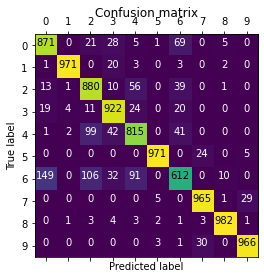

In [35]:
import sklearn
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_predicted_labels)
plt.matshow(cm)
plt.title('Confusion matrix')
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] < thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
classes = range(10) # Labels are sorted 
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.grid(False)
plt.show()

In [36]:
tuner.delete_endpoint()

The function delete_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Good reference

https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#deploying-directly-from-model-artifacts